ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
/tmp/ipykernel_10393/391608825.py:149: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_f

[0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1]


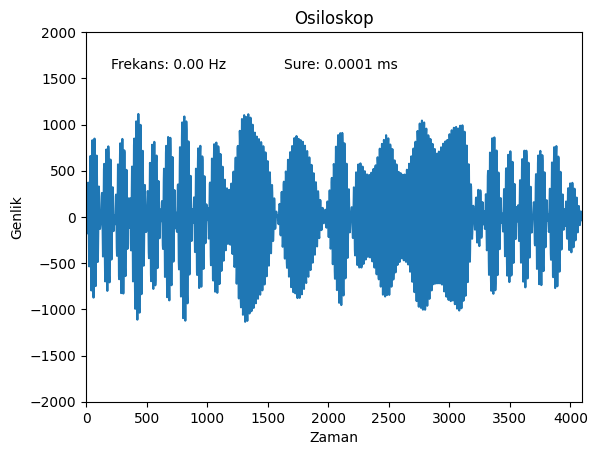

In [20]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import hilbert, butter, filtfilt
import time
from pyldpc import make_ldpc, encode, decode, get_message
# Ses kayıt parametreleri
CHUNK = 1024 * 2  # Her seferde alınacak örnek sayısı
FORMAT = pyaudio.paInt16  # Örnek formatı
CHANNELS = 1  # Kanal sayısı
RATE = 44100  # Örnekleme hızı

# PyAudio nesnesi oluştur
p = pyaudio.PyAudio()

# Giriş akışını aç (mikrofonu dinleme)
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=CHUNK
)

# Butterworth band-pass filtre tasarımı
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Bitleri çözmek için fonksiyon
def bitleri_cozumle(data):
    mesaj_baslangici = [1, 1, 1]
    mesaj_bitisi = [0, 1, 0]

    # Eşik değeri kullanarak bitleri belirleme
    threshold = 0
    bitler = (data > threshold).astype(int)

    # Mesajın başlangıç ve bitiş bitlerini bulma
    for i in range(len(bitler) - 16):
        if (bitler[i:i+3].tolist() == mesaj_baslangici and 
            bitler[i+13:i+16].tolist() == mesaj_bitisi):
            return bitler[i:i+16].tolist()
    return None
    
    
def al(data):
	n = 32
	d_v = 4
	d_c = 8
	snr = 20
	H, G = make_ldpc(n, d_v, d_c, systematic=True, sparse=True)
	gruplar = [data[i:i+64] for i in range(0, len(data), 64)]
	ana_ort=np.abs(np.mean(data))
	ortalamalar =[]
	
	for grup in gruplar:
		ortalama=np.mean(grup)
		if ortalama <=0:
			ortalamalar.append(-1)
		else:
			ortalamalar.append(1)
	ortalamalar=np.array(ortalamalar)	
	#print(ortalamalar[0])	
	d = decode(H, ortalamalar, snr)
	x=get_message(G, d)
	
	#print(ortalamalar)
			
	return x

# Frekans aralığı
lowcut = 4500.0
highcut = 5500.0

# Grafik hazırlıkları
fig, ax = plt.subplots()
x = np.arange(0, 2 * CHUNK, 2)
line, = ax.plot(x, np.random.rand(CHUNK))

ax.set_ylim(-2000, 2000)
ax.set_xlim(0, 2 * CHUNK)
plt.xlabel('Zaman')
plt.ylabel('Genlik')
plt.title('Osiloskop')

# Frekans değeri için metin ekleyin
text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
text2 = ax.text(0.4, 0.9, '', transform=ax.transAxes)

# Mesaj için metin ekleyin
message_text = ax.text(0.05, 0.85, '', transform=ax.transAxes)
t = np.arange(0, CHUNK) / RATE
tasiyici_dalga = np.sin(2 * np.pi * 5000 * t)
tasiyici_dalga=np.where(tasiyici_dalga==0,1e-10,tasiyici_dalga)

def update_frame(frame):
    # Ses verilerini oku
    baslama_zamani = time.time()
    data = stream.read(CHUNK, exception_on_overflow=False)
    data_int = np.frombuffer(data, dtype=np.int16)
    bitme_zamani = time.time()
    gecen_sure = bitme_zamani - baslama_zamani


    
    # Band-pass filtre uygulama
    filtered_data = bandpass_filter(data_int, lowcut, highcut, RATE, order=6)*5
    
    # Frekans spektrumunu hesapla
    frekans = np.fft.rfftfreq(len(data_int), 1/RATE)
    spektrum = np.fft.rfft(data_int)
    frekans_peak = frekans[np.argmax(np.abs(spektrum))]
    m2=filtered_data
    #print("eleman :",m2[0])
    d=np.array(m2)
    #print("m2 :",np.sum(d<=0))
    genis_veri=(m2/tasiyici_dalga +1)/2
    #print("genis_veri :",np.sum(genis_veri<=0))
    genis_veri=np.where(genis_veri <=0,-1,1)
    

    
    # Veriyi güncelle
    line.set_ydata(filtered_data)
    if frekans_peak >lowcut  and frekans_peak<highcut:
        #print(genis_veri[:19])
        print(al(genis_veri))
    
    # Frekans değerini güncelle
    text.set_text(f'Frekans: {frekans_peak:.2f} Hz')
    text2.set_text(f'Sure: {gecen_sure:.4f} ms')

    # Bitleri çözümle ve mesajı yazdır
    #demodulated_signal = hilbert(filtered_data).real
    
    return line, text, message_text

# Animasyonu başlat
ani = animation.FuncAnimation(fig, update_frame, interval=1, blit=True)

# Grafik gösterimi
plt.show()

# Akışı kapat ve kaynakları serbest bırak
stream.stop_stream()
stream.close()
p.terminate()
